In [1]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


# param setting

In [3]:
EPOCHS = 200
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='ver_8_model_type'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [4]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

# Data scaling

In [5]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

# Make custom dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

# AE Model

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(64,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

# Training class

In [8]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, index):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            
            #print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+str(index)+'.pth')
                #print("Save Model~_~")
                
            #plt.plot(mse_list)
            #plt.show()
            
            
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

# train each class

In [9]:
def get_anomaly_scores(df_original, df_restored):
        loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
        loss = pd.Series

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


0
Counter({0: 1137, 1: 159})


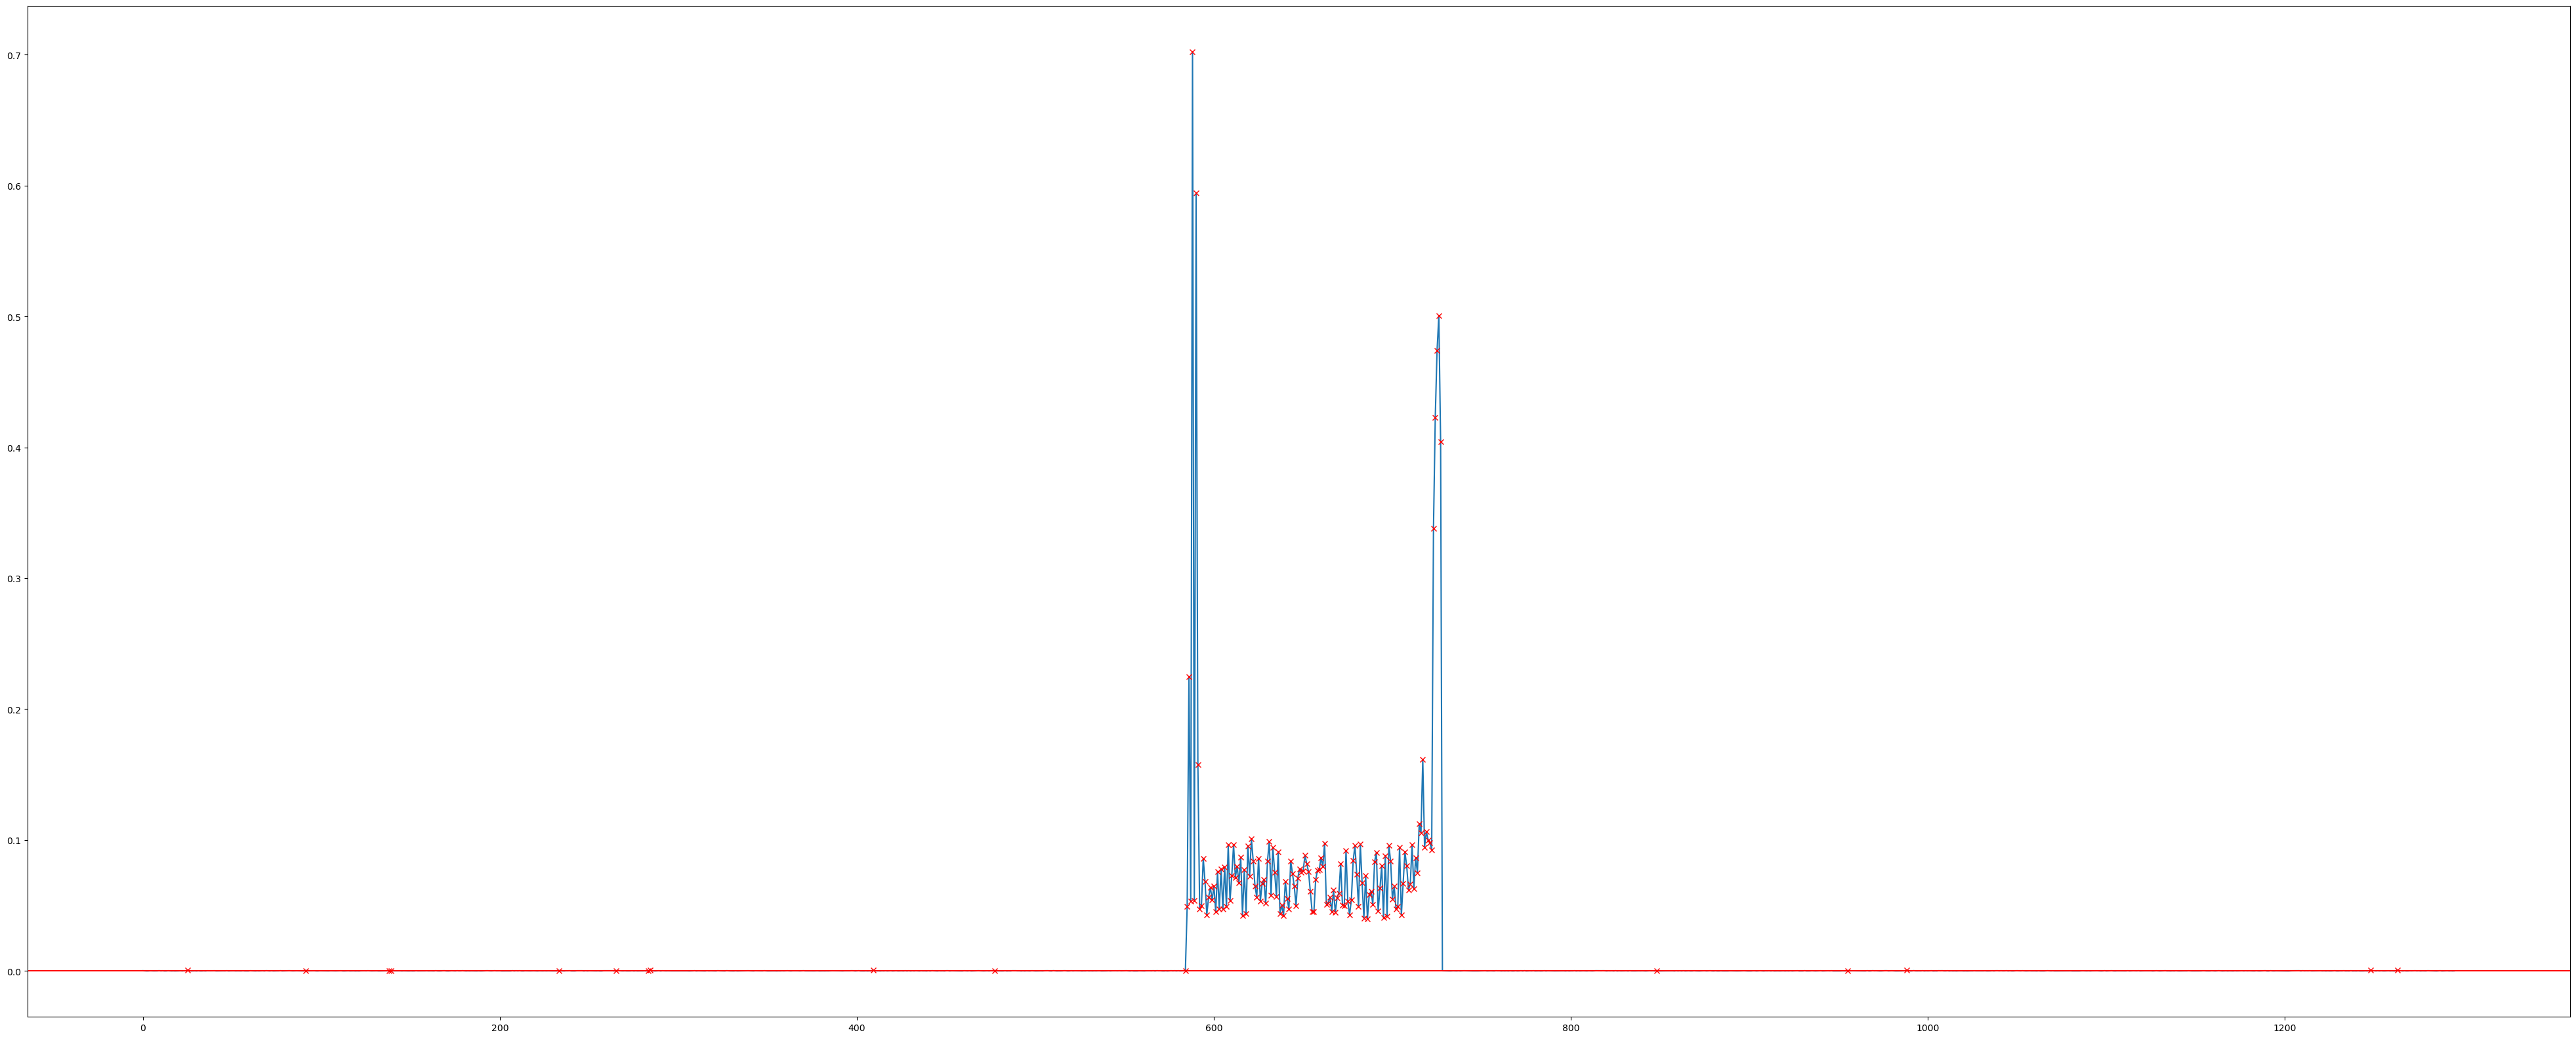

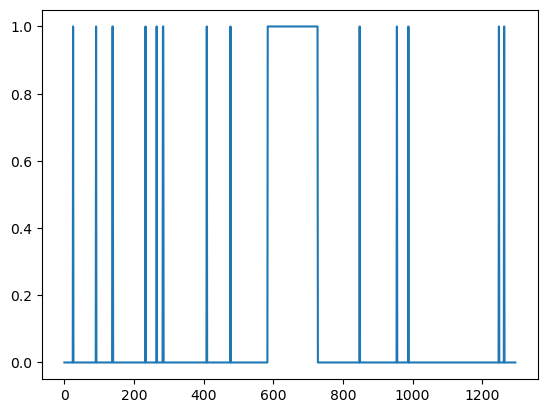

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


1
Counter({1: 902, 0: 205})


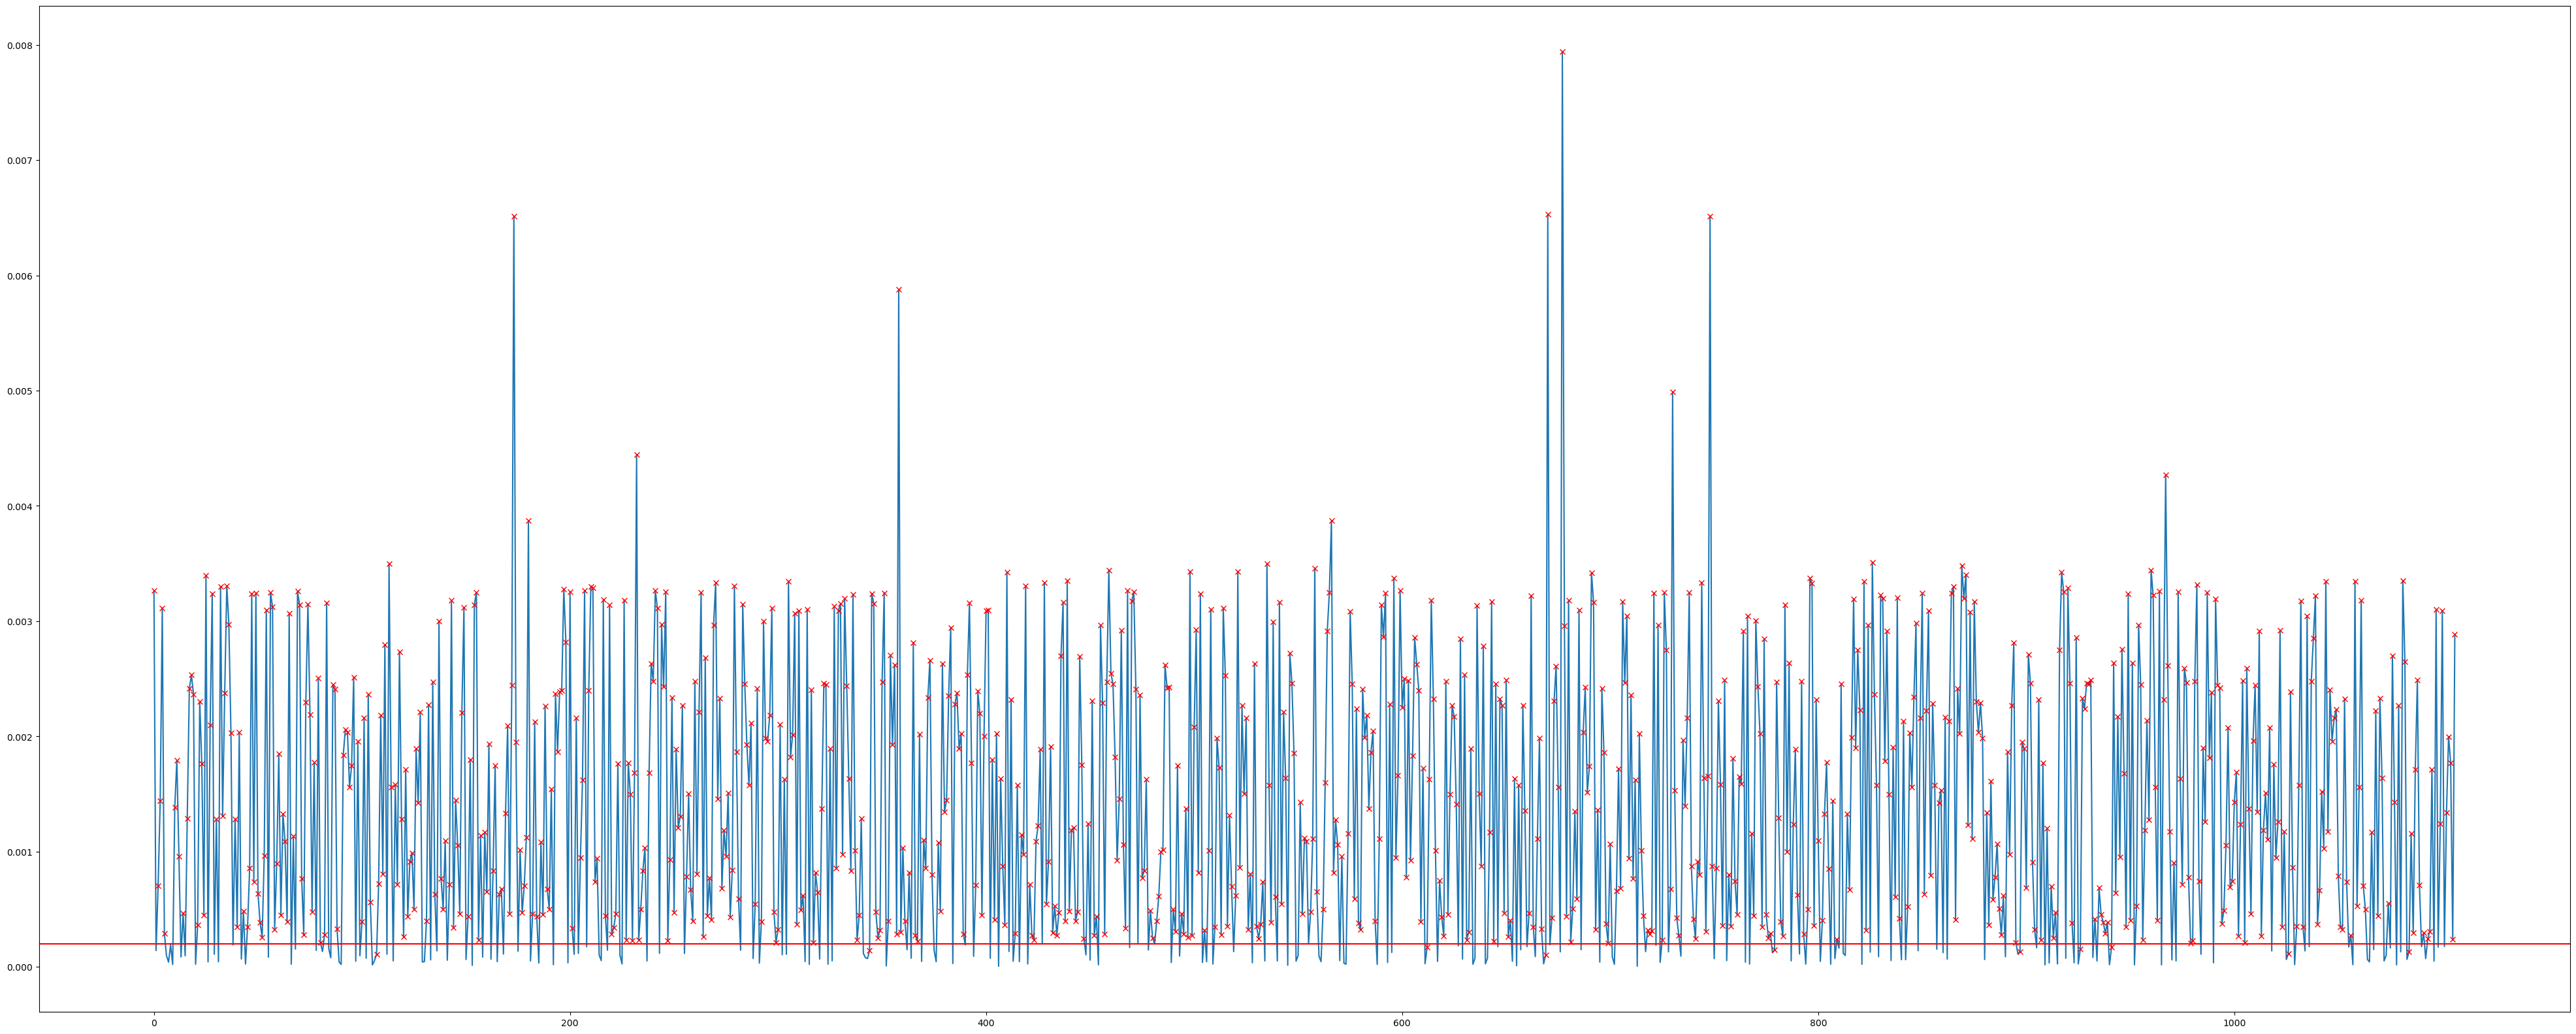

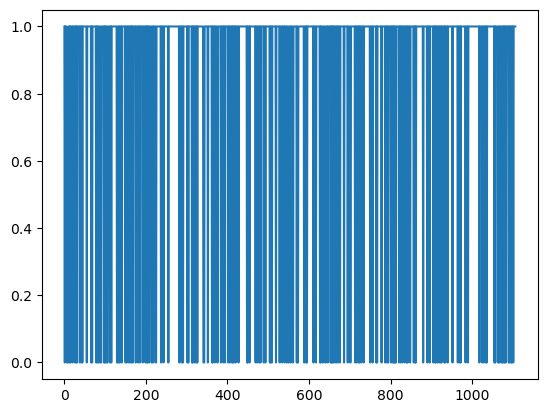

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


2
Counter({0: 939, 1: 159})


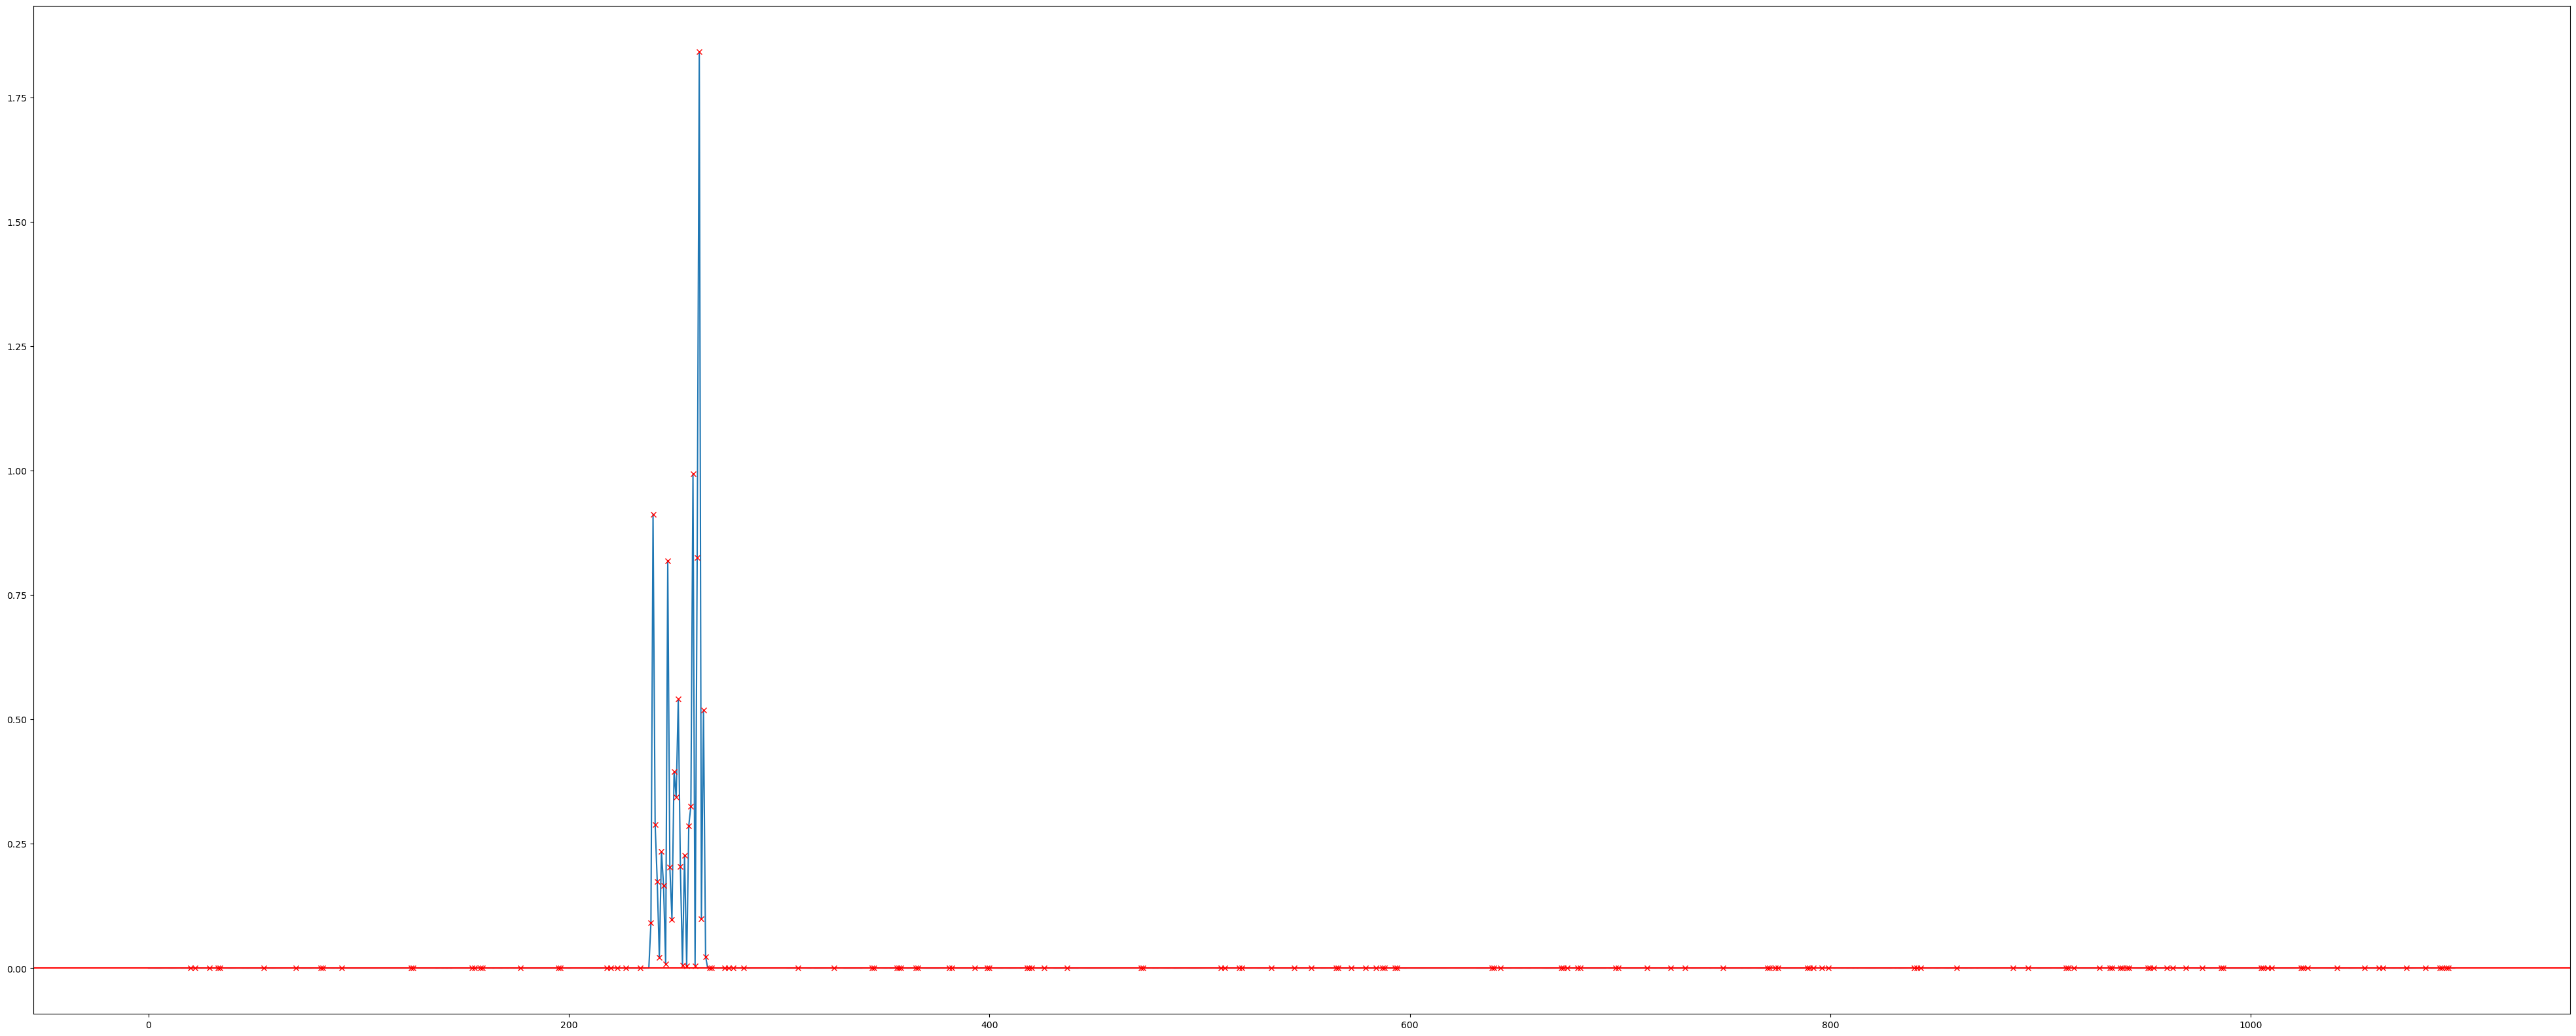

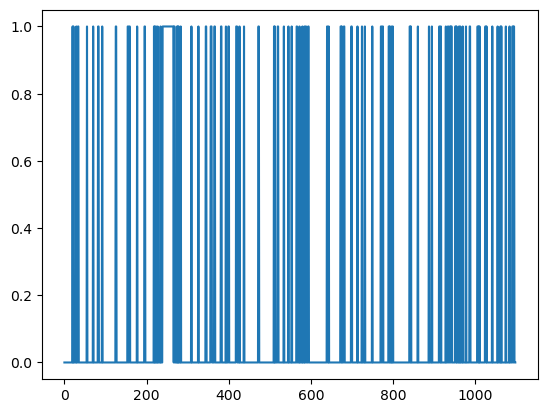

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


3
Counter({0: 590, 1: 328})


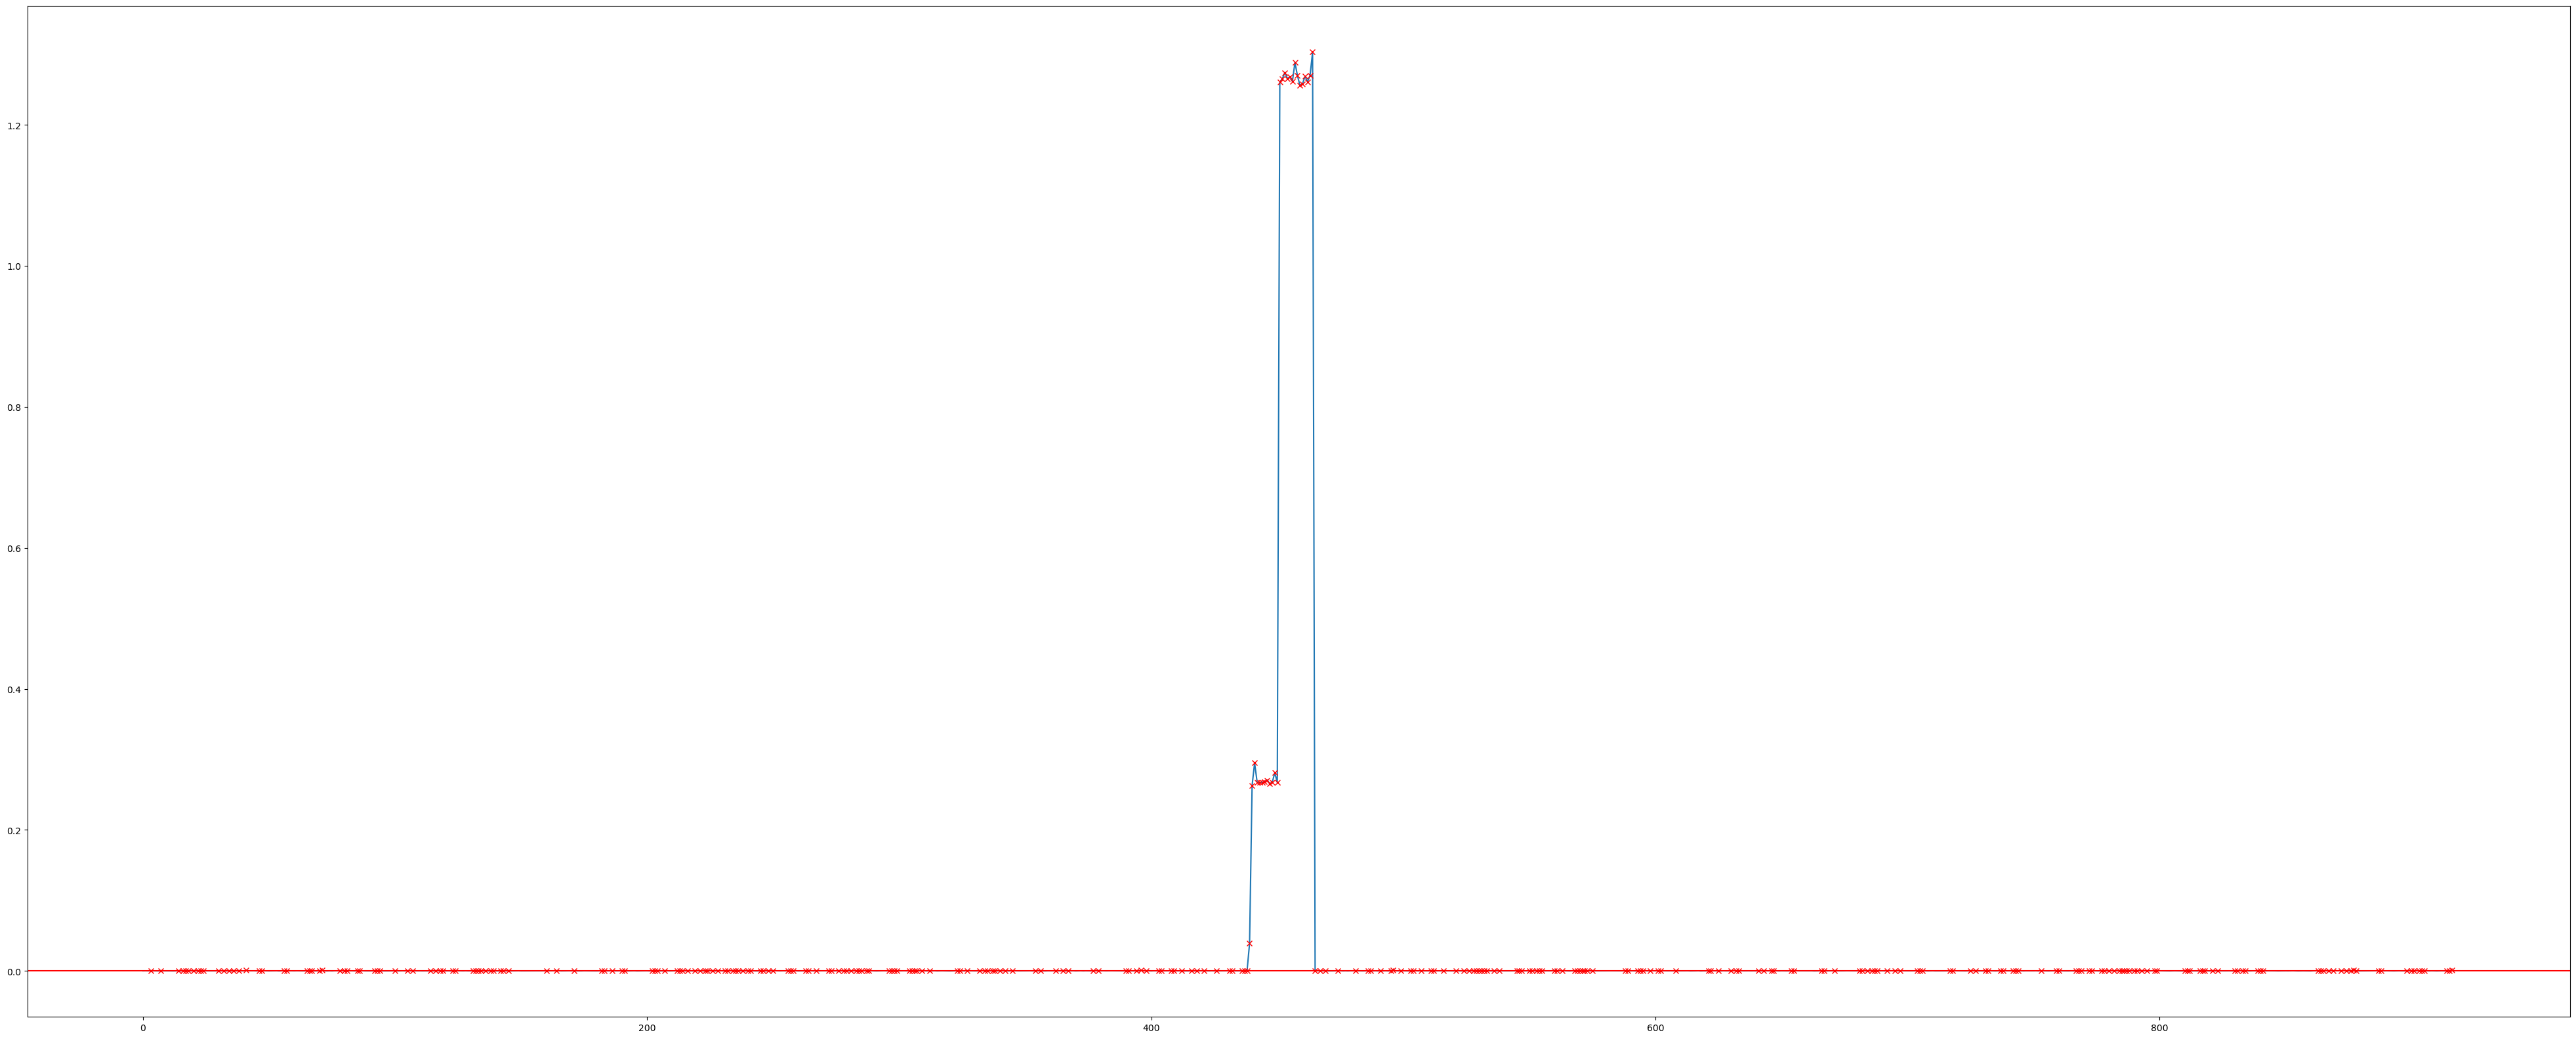

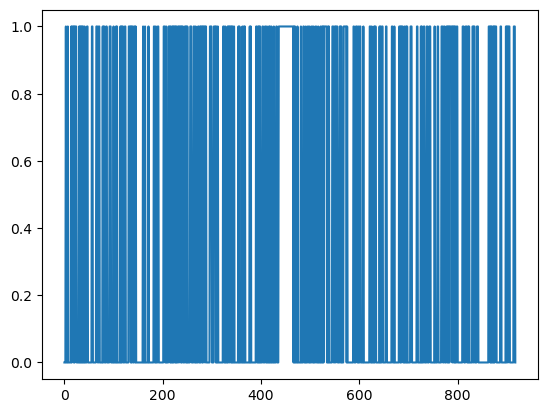

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


4
Counter({0: 742, 1: 176})


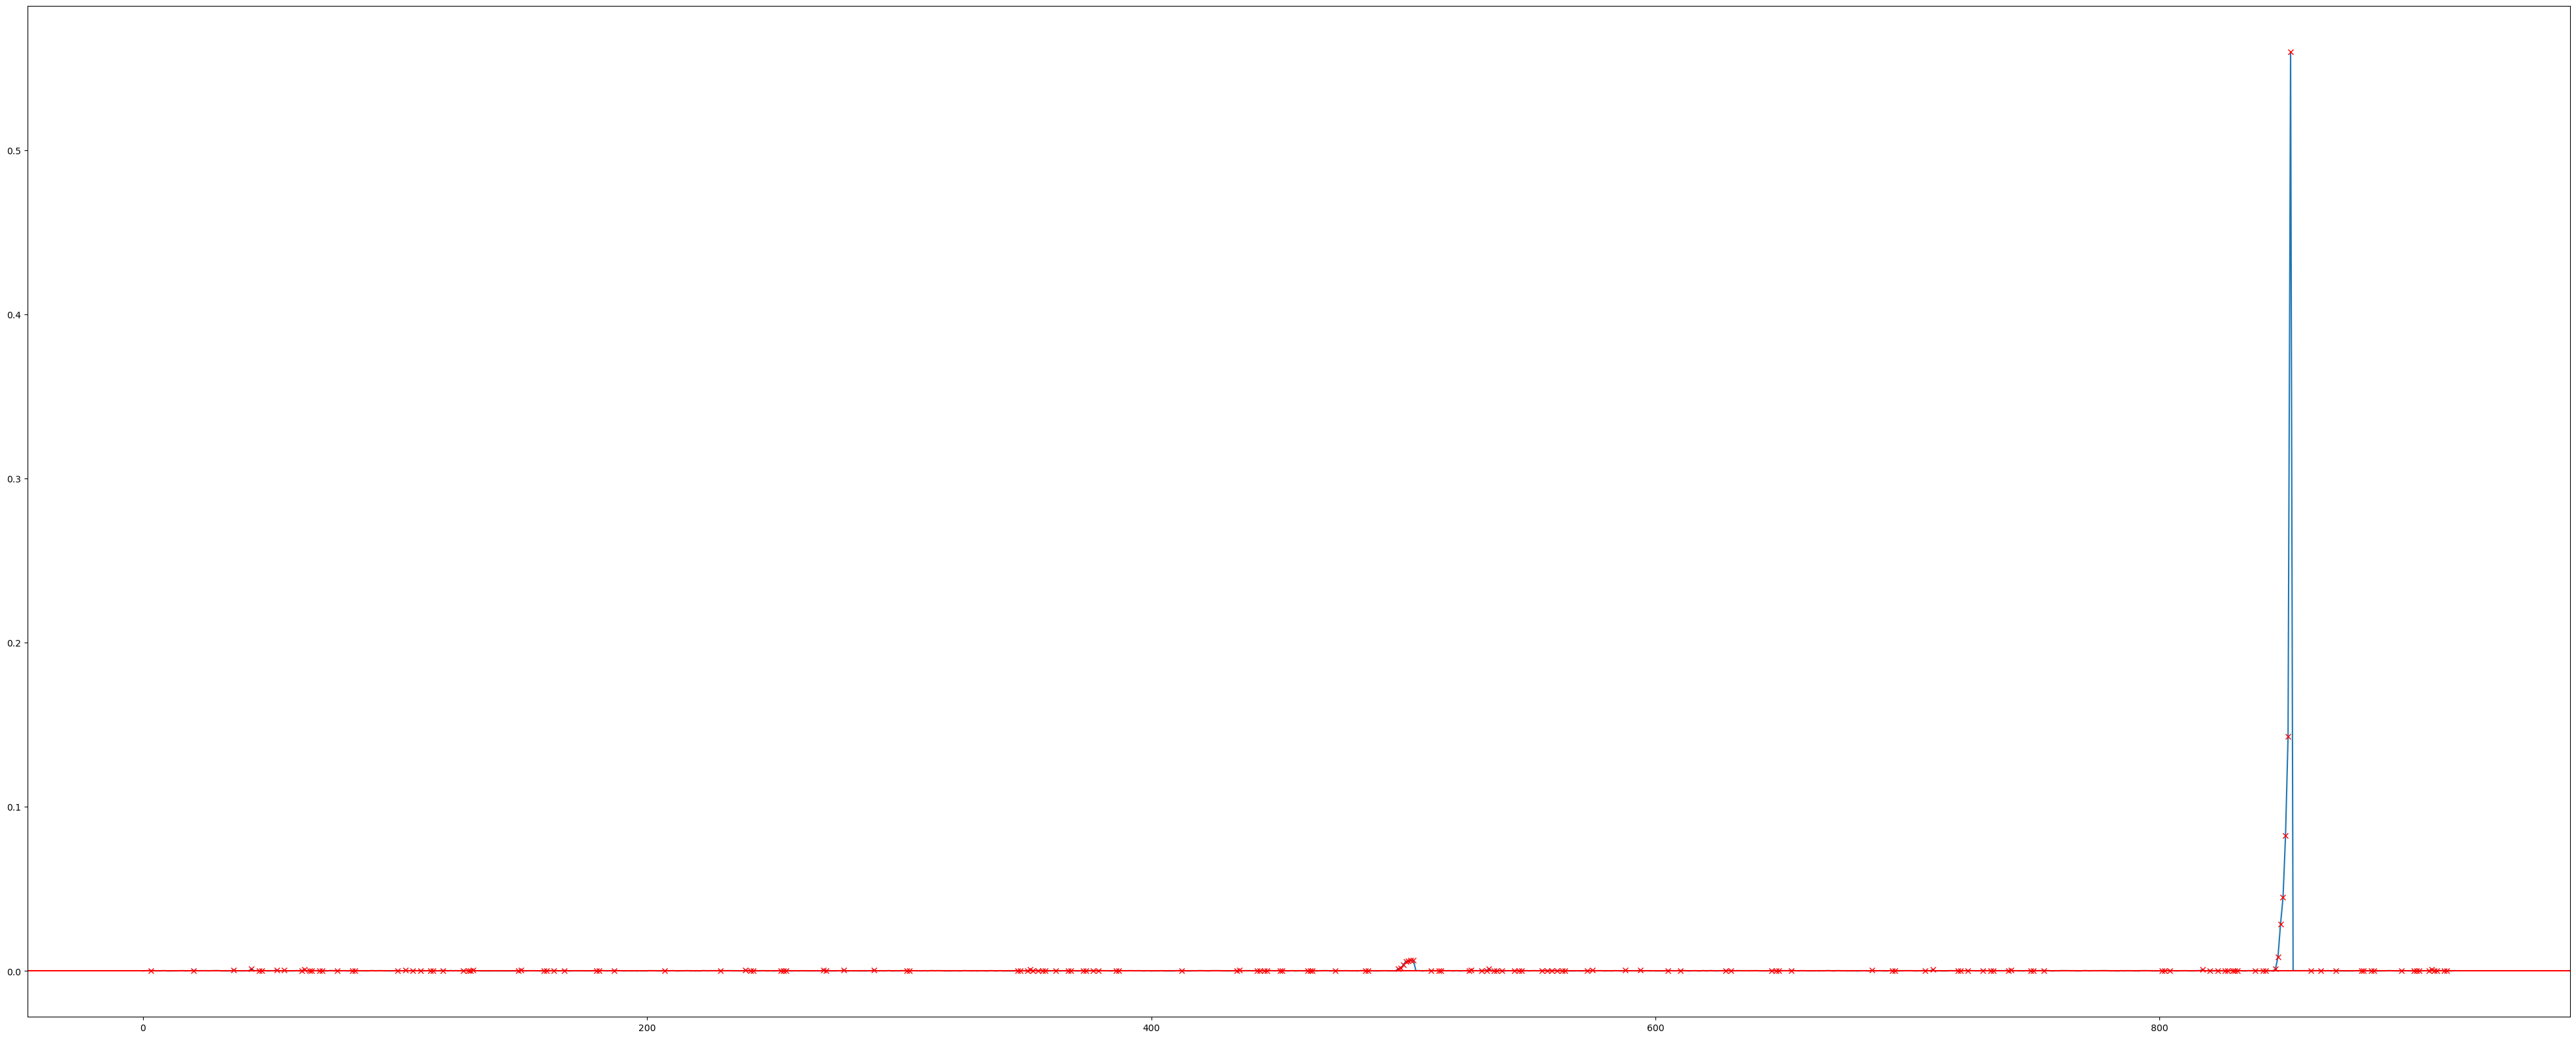

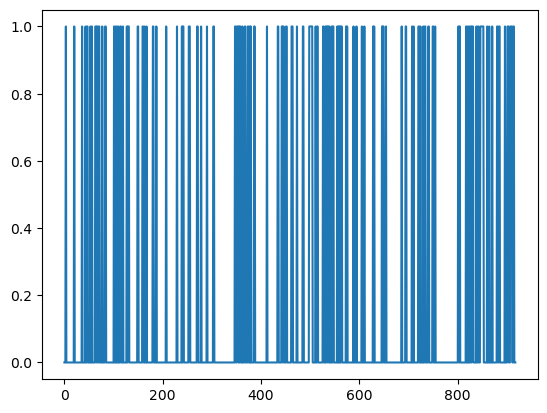

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


5
Counter({0: 561, 1: 186})


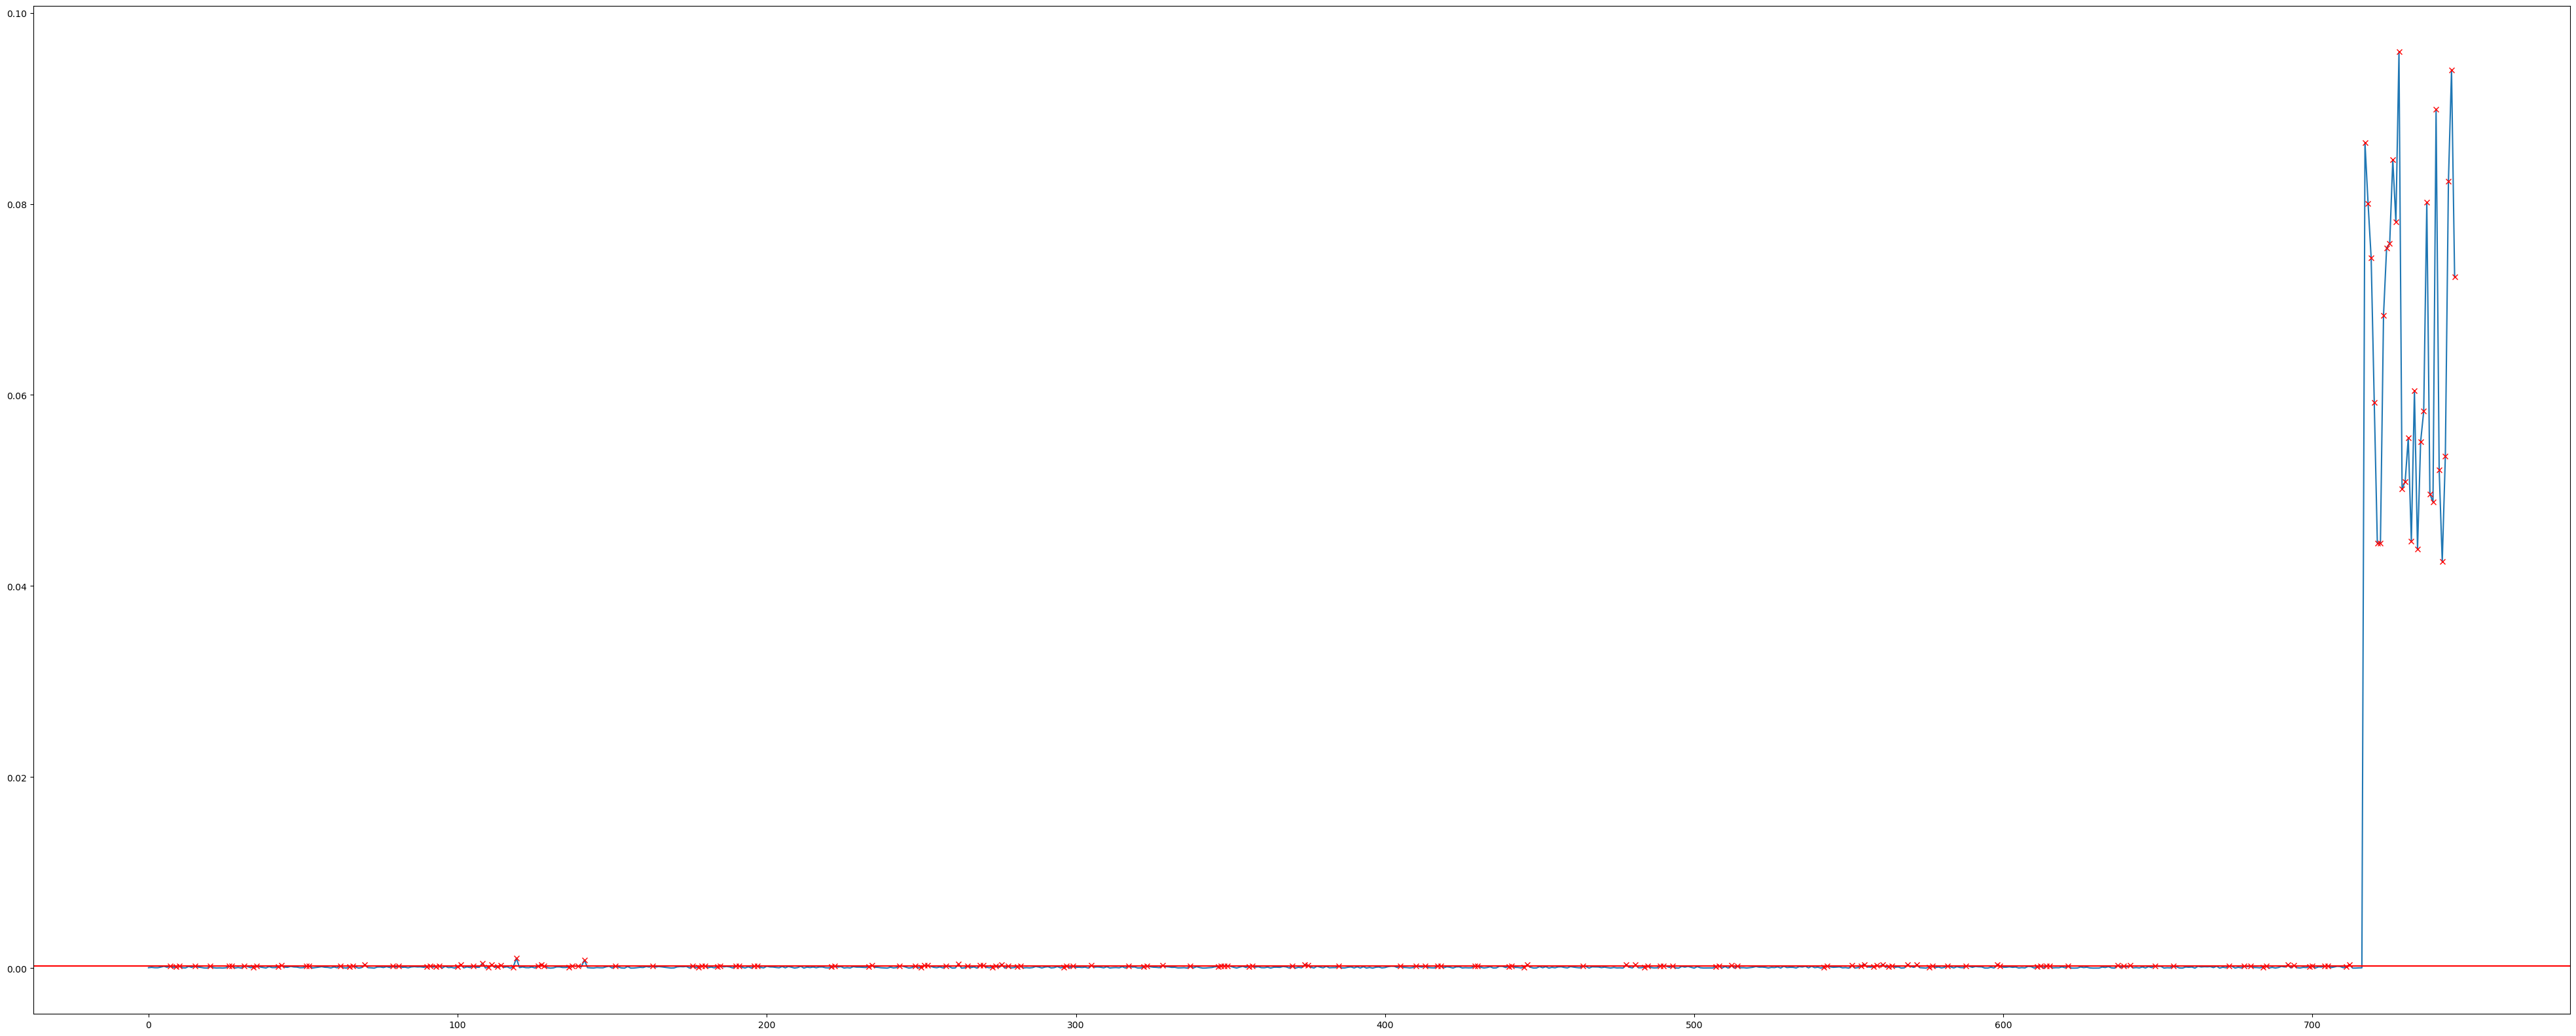

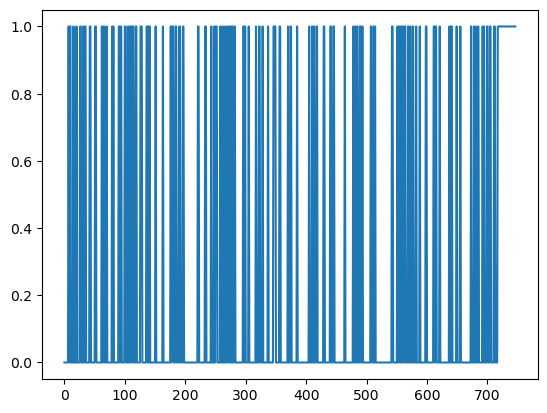

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


6
Counter({0: 443, 1: 304})


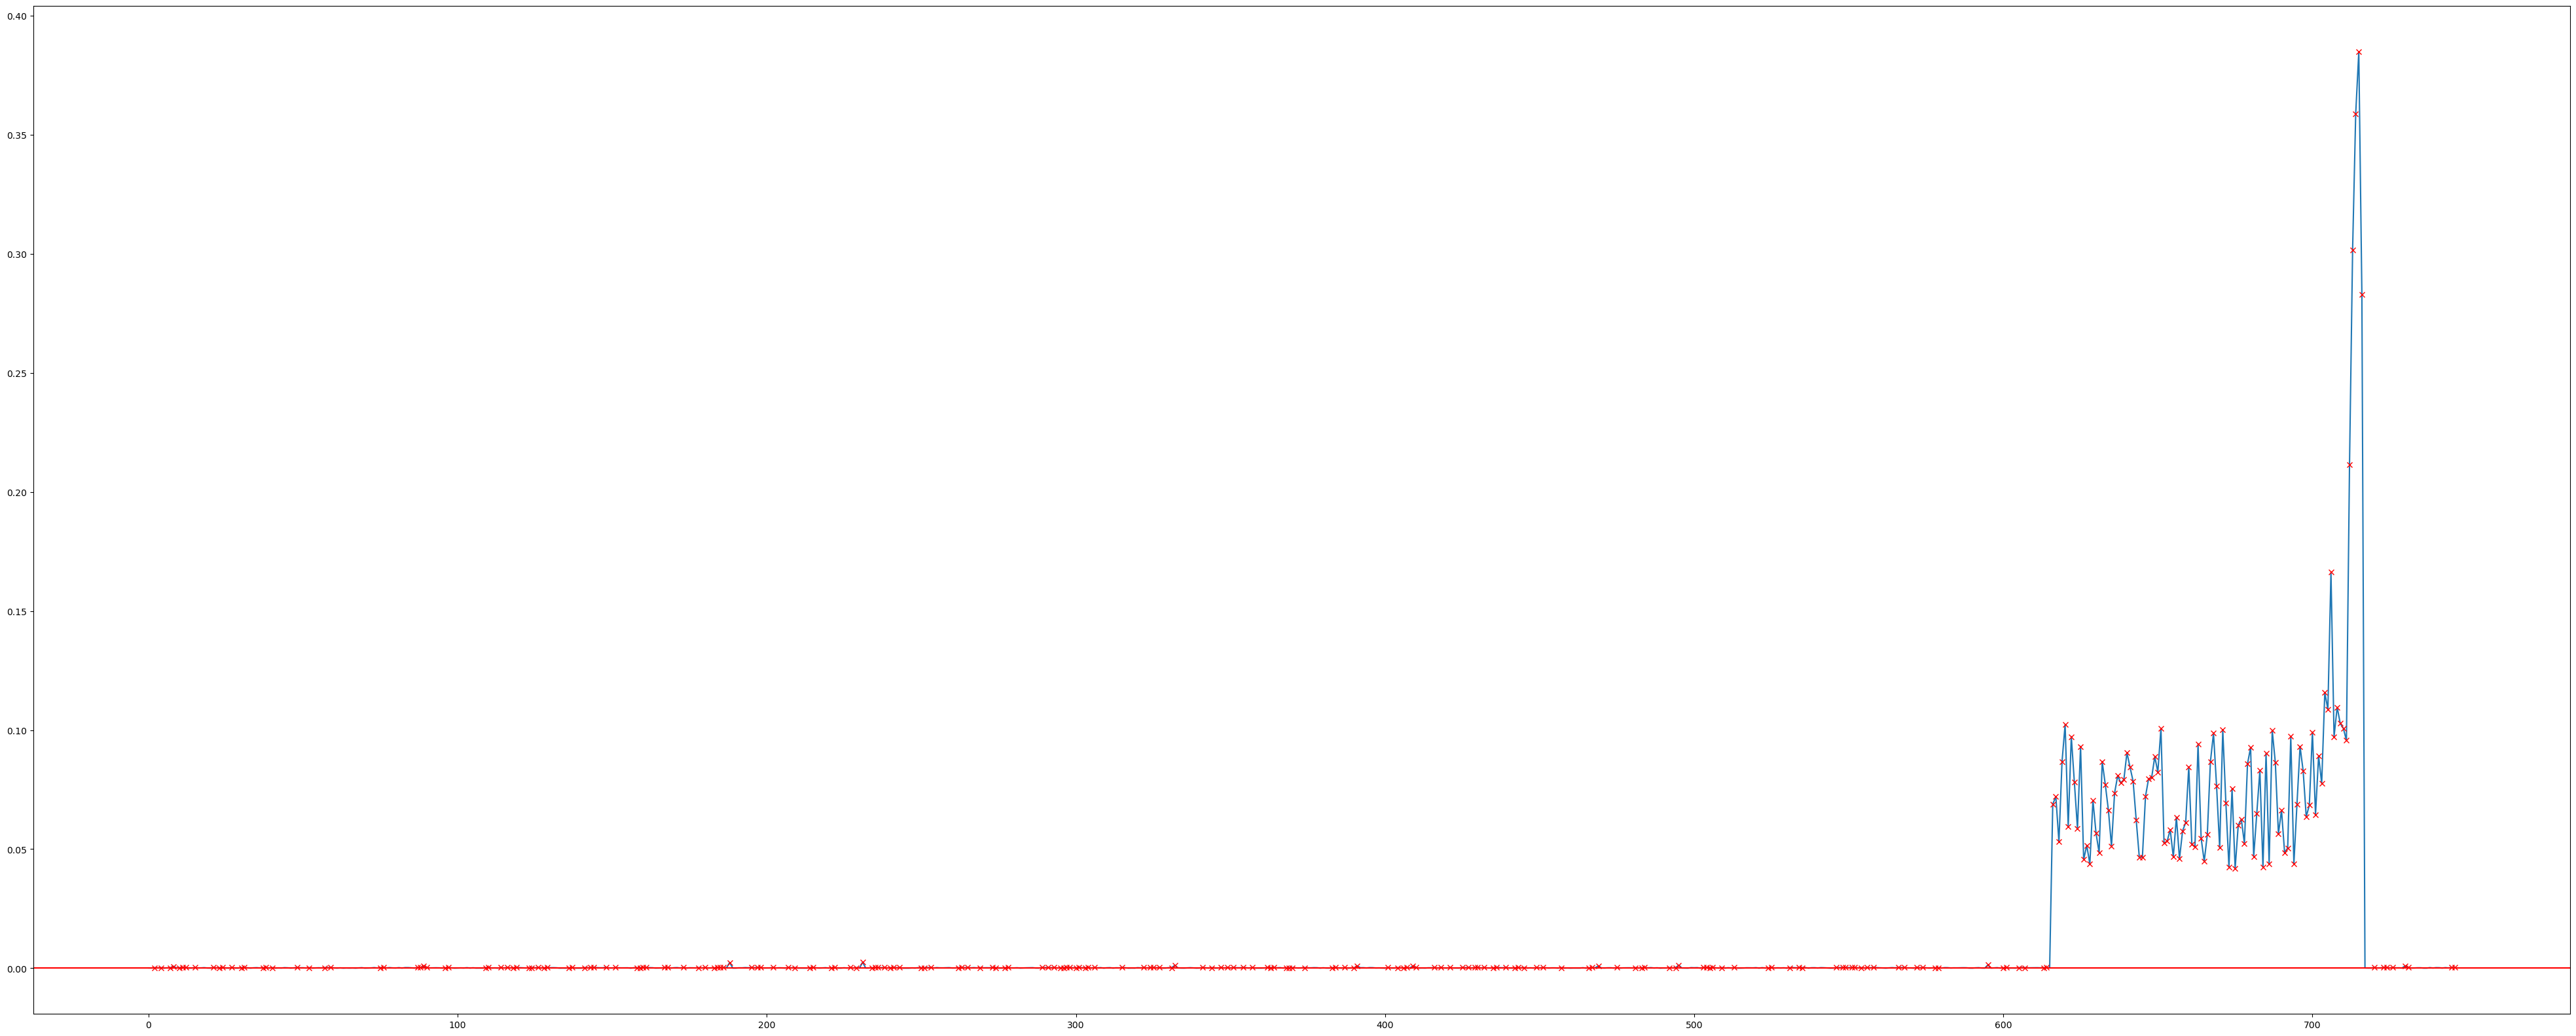

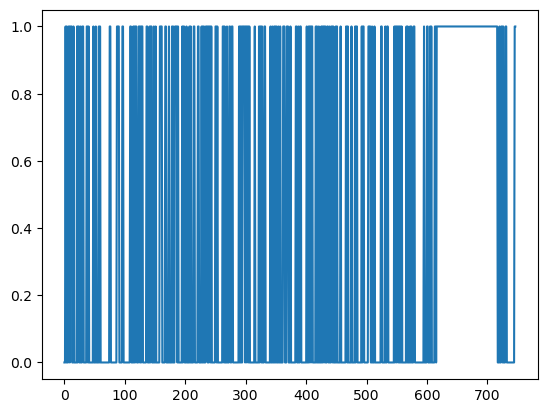

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26074/2576471990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


7
Counter({0: 312, 1: 246})


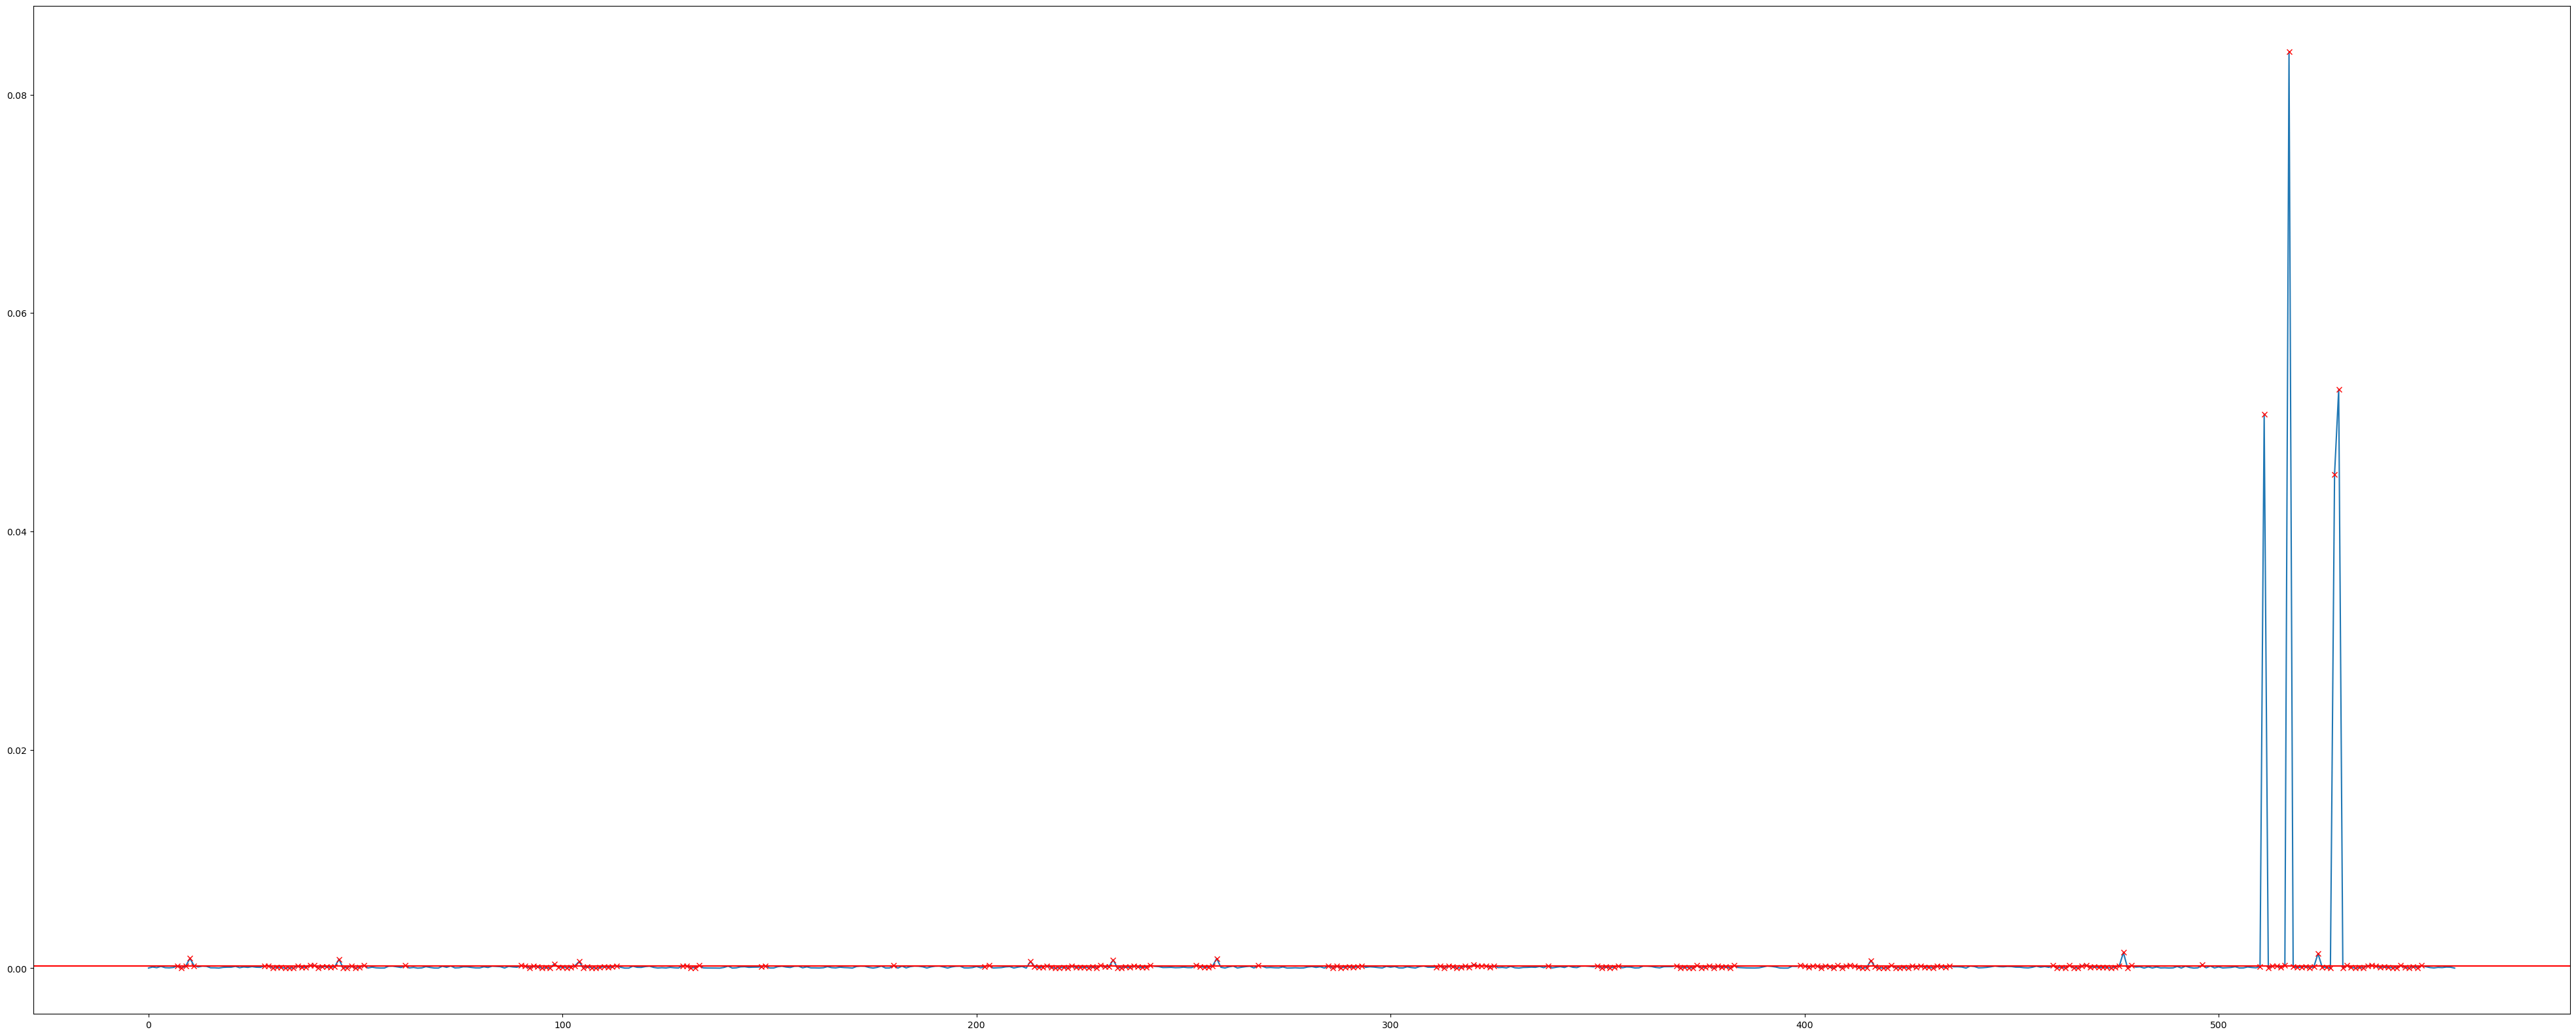

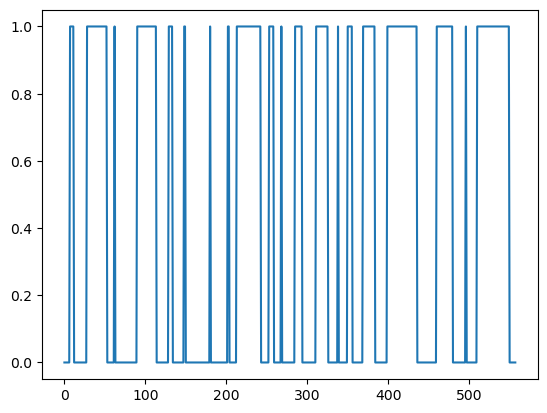

In [36]:
scaler_list = []
pred = []
for i in range(8):
    train_data = train_each_list[i]
    #train_data = train_data.loc[train_data['motor_vibe'] < 10]
    train_data['label'] = 'train'
    train_data_drop = train_data.drop(['type','label'], axis=1)
    #train_x, val_x = train_test_split(train_data_drop, test_size = 0.3, random_state=SEED, shuffle=True)
    
      
    test_type = test_df.loc[test_df['type']==i]
    test_type['label'] = 'test'
    test_data_drop = test_type.drop(['type','label'], axis=1)
    
    print(i)
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_data_drop)
    test_x = scaler.transform(test_data_drop)
    
    pca = KernelPCA(n_components = 2, kernel = 'poly', random_state=SEED, fit_inverse_transform=True)
    pca.fit(train_x)
    #print(pca.explained_variance_ratio_)
    
    test_pca = pca.transform(test_x)
    test_restore = pca.inverse_transform(test_pca)
    
    error = test_x - test_restore
    mse = np.mean(np.power(error,2),axis=1)
    
    tmp = np.where(mse > 0.0002, 1, 0)
    if i == 7: # type 7에 한정하여 특수하게 조건 적용
        if len(tmp) > 10:
            for idx in range(len(tmp)-10):
                for k in range(2,10):
                    if tmp[idx]==1 and tmp[idx+k]==1:
                        for j in range(1,k):
                                tmp[idx+j] = 1

        elif len(tmp) <= 10 and len(tmp) > 2:
             for idx in range(len(tmp)):
                for k in range(2,len(tmp)-idx):
                    if tmp[idx]==1 and tmp[idx+k]==1:
                        for j in range(1,k):
                                tmp[idx+j] = 1
                                
#        for index in range(len(tmp)):
#            if tmp[index] == 1:
#                print(index)

            
    #warm up
    if len(tmp) > 2:
        for idx in range(2, len(mse)):
            if tmp[idx]==1 and mse[idx-1] > mse[idx-2] and mse[idx-1] > 0.0001:
                tmp[idx-1]=1
                
    print(Counter(tmp))
    plt.figure(figsize=(50,20))
    plt.plot(mse)
    #plt.ylim([0,0.01])
    for i in range(len(tmp)):
        if tmp[i] == 1:
            plt.plot(i, mse[i], 'rx')
    plt.axhline(0.0002,color='r')
    plt.show()
    plt.plot(tmp)
    plt.show()
    pred.extend(tmp)
    

# Predict

In [33]:
zero = 0
one = 0
for i in range(len(pred)):
    if pred[i] == 0:
        zero = zero+1
    else:
        one = one+1    
print(f'{zero}, {one}')

7039, 350


In [25]:
submit = pd.read_csv('./dataset/answer_sample.csv')
submit['label'] = pred
submit.to_csv(f'./AE_6.csv')